In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.densenet import DenseNet169,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = DenseNet169(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(10136, 1, 1, 1664)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(10136, 1664)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)

In [ ]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 16.1min


[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.137795, total= 9.7min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137255, total= 9.7min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138477, total= 9.7min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137695, total= 9.7min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.136986, total= 9.7min
[CV] .............. C=0.01, gamma=1e-07, score=0.139165, total= 9.7min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137795, total= 9.8min
[CV] C

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 16.7min


[CV] .............. C=0.01, gamma=1e-07, score=0.136986, total=10.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137695, total=10.1min
[CV] .............. C=0.01, gamma=1e-07, score=0.137795, total=10.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137255, total=10.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.139165, total=10.1min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.139442, total=10.1min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.138889, total=10.1min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 16.8min


[CV] ............ C=100.0, gamma=0.0001, score=0.946850, total= 1.5min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.943620, total= 1.5min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.947473, total= 1.5min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.943452, total= 1.4min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.944334, total= 1.4min
[CV] C=100.0, gamma=0.1 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.938247, total= 1.4min
[CV] C=100.0, gamma=0.1 ..............................................
[CV] ............. C=100.0, gamma=0.001, score=0.946289, total= 1.6min
[CV] C=100.0, gamma=0.1 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 277.4min


[CV] .............. C=100.0, gamma=0.01, score=0.951772, total= 4.3min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.940653, total= 4.3min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.946482, total= 4.3min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.938492, total= 4.3min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.942346, total= 4.3min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.941235, total= 4.1min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............... C=100.0, gamma=0.1, score=0.579102, total=11.1min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 305.1min


[CV] ............ C=1000.0, gamma=1e-08, score=0.415354, total= 9.3min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.803711, total= 4.4min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.818982, total= 4.5min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.791176, total= 4.4min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.793307, total= 4.4min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.301181, total=14.1min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.413386, total= 9.1min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 312.1min


[CV] ............ C=1000.0, gamma=1e-06, score=0.917740, total= 2.0min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.945491, total= 1.5min
[CV] ............ C=1000.0, gamma=1e-05, score=0.941468, total= 1.4min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.943340, total= 1.5min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-06, score=0.899802, total= 2.0min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-06, score=0.907555, total= 2.0min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.941235, total= 1.5min
[CV] C=1000.0, gamma=0.01 ............................................
[CV] .

In [16]:
top_model.cv_results_

{'mean_fit_time': array([551.30904729, 555.54093788, 540.14243166, 558.23819723,
        580.83493409, 529.6161422 , 514.60739329, 694.44899936,
        793.09028947, 799.02880774, 540.42581663, 552.5655091 ,
        549.58846068, 574.55872207, 508.33362787, 252.2262321 ,
        259.78949678, 653.70268722, 773.24061005, 781.7139478 ,
        553.67878802, 551.69929342, 562.06623111, 516.22171175,
        230.28382101, 108.3611063 , 214.59319501, 629.40469646,
        746.40476828, 793.21819773, 551.86639709, 567.97363563,
        510.40027492, 228.27709346, 100.26564131,  80.03893952,
        231.32712159, 641.63876588, 765.15372717, 811.716085  ,
        565.38299661, 509.97504652, 228.32037728,  99.85840292,
         71.8414782 ,  79.01307826, 234.46472399, 634.58036697,
        780.03595252, 808.97583189, 510.26852593, 230.8595711 ,
        100.39532673,  70.84579906,  69.87610602,  79.56709163,
        230.12658291, 639.81045516, 767.67006805, 662.55038664]),
 'mean_score_time': a

In [17]:
top_model.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1e-07},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1e-06},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1e-05},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.39098, std: 0.00362, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.43765, std: 0.00692, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.26776, std: 0.00977, params: {'C': 0.01, 'gamma': 0.1},
 mean: 0.20777, std: 0.00634, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.15361, std: 0.00250, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.13822, std: 0.00079, params: {'C': 0.1, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.1, 'gamma': 1e-07},
 mean: 0.13822, std: 0.00079, params: {'C': 0.1, 'gamma': 1e-06},
 mean: 0.13822, std: 0.00079, params: {'C': 0.1, 'gamma': 1e-05},
 mean: 0.41160, std: 0.00246, params: {'C': 0.1, 'gamma': 0.0001},
 mea

In [18]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 100.0, 'gamma': 0.001} - score: 0.9470


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


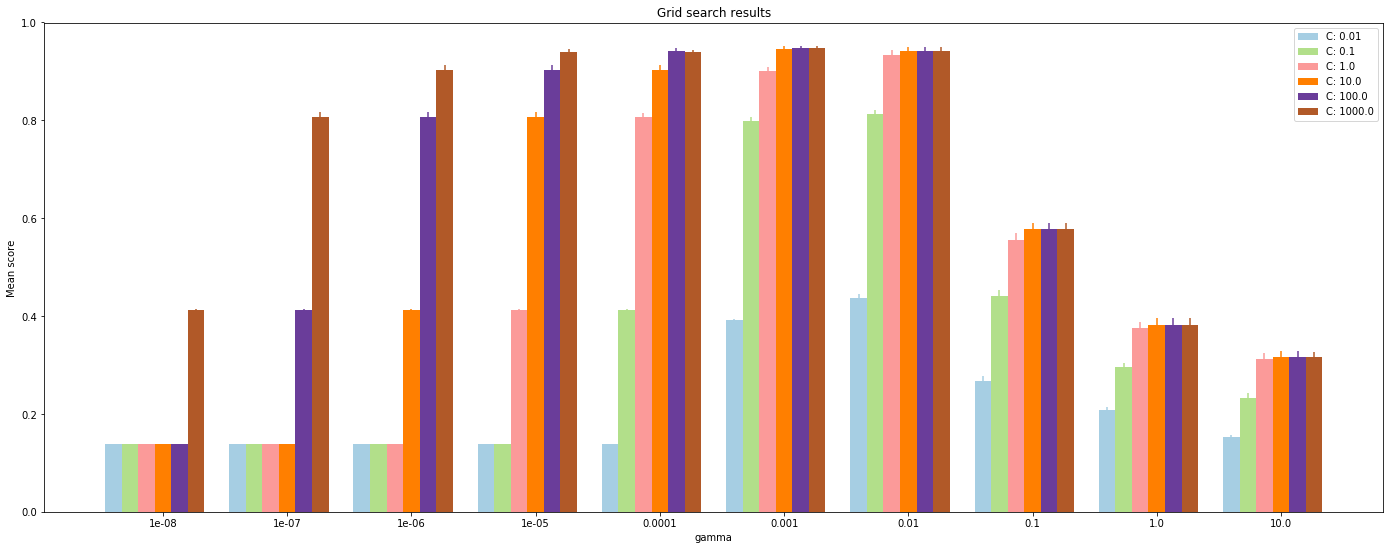

In [19]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()